<a href="https://colab.research.google.com/github/namoshi/thresh/blob/main/kurita_thresh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, io
#from skimage.filters import threshold_otsu
#from threshold_kurita import threshold_kurita
from skimage.exposure import histogram


In [3]:
def threshold_kurita(image, nbins=256, method='otsu'):
    """Return threshold value based on Kurita's method.
    Parameters
    ----------
    image : (N, M) ndarray
        Grayscale input image.
    nbins : int, optional
        Number of bins used to calculate histogram. This value is ignored for
        integer arrays.
    Returns
    -------
    threshold : float
        Upper threshold value. All pixels with an intensity higher than
        this value are assumed to be foreground.
    Raises
    ------
    ValueError
         If ``image`` only contains a single grayscale value.
    References
    ----------
    .. [1] https://www.sciencedirect.com/science/article/pii/003132039290024D
    Examples
    --------
    >>> from skimage.data import camera
    >>> image = camera()
    >>> thresh = threshold_kurita(image)
    >>> binary = image <= thresh
    Notes
    -----
    The input image must be grayscale.
    """
    if len(image.shape) > 2 and image.shape[-1] in (3, 4):
        msg = "threshold_otsu is expected to work correctly only for " \
              "grayscale images; image shape {0} looks like an RGB image"
        warn(msg.format(image.shape))

    # Check if the image is multi-colored or not
    if image.min() == image.max():
        raise ValueError("threshold_otsu is expected to work with images "
                         "having more than one color. The input image seems "
                         "to have just one color {0}.".format(image.min()))

    
    height, width = image.shape
#    print(height, width)

    hist, bin_centers = histogram(image.ravel(), nbins, source_range='image')
    hist = hist.astype(float)/(height * width)

#    print('hist', len(hist))
#    print(bin_centers)
#    print(bin_centers[::-1])
    
    # class probabilities for all possible thresholds
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
#    weight2 = 1 - weight1
#    print('weight1\n', len(weight1))
#    print(weight1)
#    print('weight2\n', len(weight2))
#    print(weight2)
#    print('weight1+weight2\n', weight1[:-1] + weight2[1:])
    
    # class means for all possible thresholds
    mean = np.sum(hist * bin_centers)
#    print('mean=', mean)

    mean1 = np.cumsum(hist * bin_centers) / weight1
    mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
#    print('mean1\n', len(mean1))
#    print('mean2\n', len(mean2))
#    print('w1*mean1+w2*mean2\n', (weight1*mean1)[:-1] + (weight2*mean2)[1:])

    # Class variances for all possible threshold
    sigma = np.sum(hist * (bin_centers**2))
#    print('sigma=', sigma)

    
    sigma1 = np.cumsum(hist * (bin_centers**2)) / weight1
    sigma1 = sigma1 - mean1**2
    sigma2 = (np.cumsum((hist * (bin_centers**2))[::-1]) / weight2[::-1])[::-1]
    sigma2 = sigma2 - mean2**2
#    print('sigma1\n', sigma1)
#    print('sigma2\n', sigma2)
    var_within = (weight1*sigma1)[:-1] + (weight2*sigma2)[1:]
#    print('var_within=w1*sigma1+w2*sigma2\n', var_within)
    var_between = sigma - var_within
#    print('var_between\n', var_between)

    if (method == 'otsu'):
#   Threshold Selection by mximization of the between class variance (var_between)
        idx = np.argmax(var_between[:-1])
        threshold = bin_centers[:-1][idx]
    elif (method == 'kittler'):
#   Threshold Selection by Kittler's Method
        kittler = np.zeros(len(hist)-1)
        for i in range(len(hist)-1):
            if (weight1[i] > 0.0 and weight2[i+1] > 0.0 and sigma1[i] > 0.0 and sigma2[i+1] > 0.0):
                kittler[i] = weight1[i]*(np.log(sigma1[i]) - np.log(weight1[i])) + weight2[i+1]*(np.log(sigma2[i+1]) - np.log(weight2[i+1]))
        
#        print(kittler)
    
        idx = np.argmax(kittler)
        threshold = bin_centers[:-1][idx]
    elif (method == 'kurita'):
#   Threshold Selection by Kittler's Method
        kurita = np.zeros(len(hist)-1)-float('inf')
        for i in range(len(hist)-1):
            if (weight1[i] > 0.0 and weight2[i+1] > 0.0 and sigma1[i] > 0.0 and sigma2[i+1] > 0.0):
                kurita[i] = weight1[i]*np.log(weight1[i]) + weight2[i+1]*np.log(weight2[i+1]) - np.log(weight1[i]*sigma1[i] + weight2[i+1]*sigma2[i+1])
        
#        print(kurita)
    
        idx = np.argmax(kurita)
        threshold = bin_centers[:-1][idx]
    else:
        print("Please select the method from 'otsu', 'kittler', and 'kurita' \n");            

    print('thresh=', threshold)
    
    # Clip ends to align class 1 and class 2 variables:
    # The last value of ``weight1``/``mean1`` should pair with zero values in
    # ``weight2``/``mean2``, which do not exist.
#    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

#    idx = np.argmax(variance12)
#    threshold = bin_centers[:-1][idx]
    
#    print('thresh=', threshold)

    return threshold


thresh= 102
method:otsu
threshold=102.000000


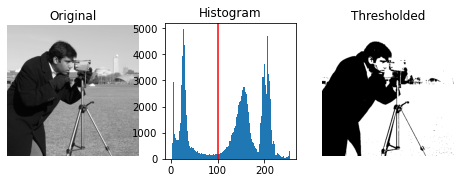

thresh= 221
method:kittler
threshold=221.000000


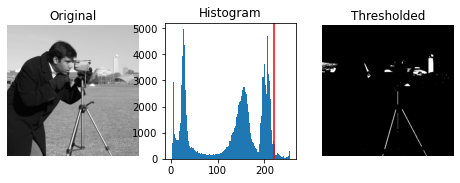

thresh= 100
method:kurita
threshold=100.000000


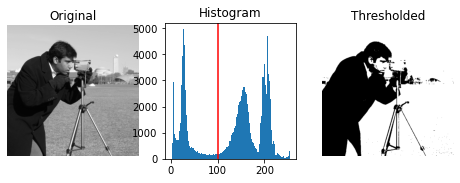

In [4]:
image = data.camera()

methods = ['otsu', 'kittler', 'kurita']

for mth in methods:
    
    thresh = threshold_kurita(image, method=mth)
    print("method:" + mth)
    print("threshold=%f"%thresh)
    
    binary = image > thresh

    fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].hist(image.ravel(), bins=256)
    ax[1].set_title('Histogram')
    ax[1].axvline(thresh, color='r')

    ax[2].imshow(binary, cmap=plt.cm.gray)
    ax[2].set_title('Thresholded')
    ax[2].axis('off')

    plt.show()
    

thresh= 146
method:otsu
threshold=146.000000


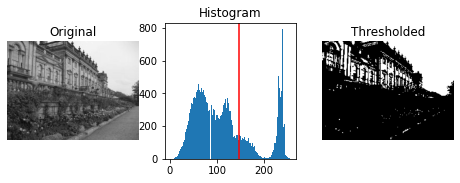

thresh= 11
method:kittler
threshold=11.000000


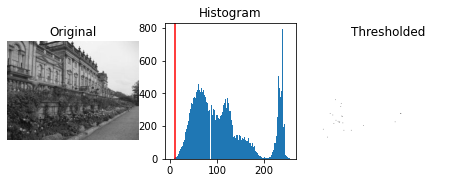

thresh= 156
method:kurita
threshold=156.000000


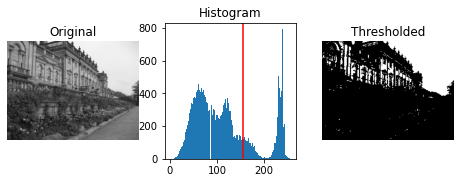

In [5]:
image = io.imread('https://github.com/namoshi/thresh/blob/main/harewood.jpg?raw=true')
methods = ['otsu', 'kittler', 'kurita']

for mth in methods:
    
    thresh = threshold_kurita(image, method=mth)
    print("method:" + mth)
    print("threshold=%f"%thresh)
    
    binary = image > thresh

    fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].hist(image.ravel(), bins=256)
    ax[1].set_title('Histogram')
    ax[1].axvline(thresh, color='r')

    ax[2].imshow(binary, cmap=plt.cm.gray)
    ax[2].set_title('Thresholded')
    ax[2].axis('off')

    plt.show()
    

thresh= 115
method:otsu
threshold=115.000000


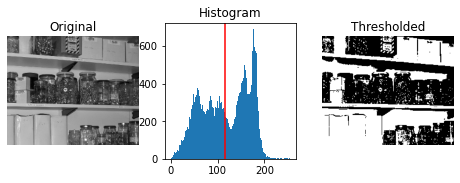

thresh= 192
method:kittler
threshold=192.000000


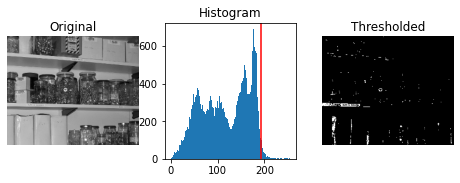

thresh= 115
method:kurita
threshold=115.000000


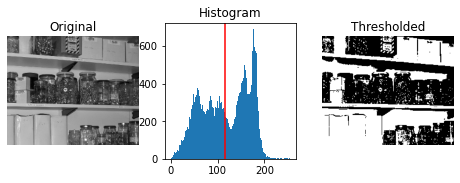

In [6]:
image = io.imread('https://github.com/namoshi/thresh/blob/main/nutsBolts.jpg?raw=true')
methods = ['otsu', 'kittler', 'kurita']

for mth in methods:
    
    thresh = threshold_kurita(image, method=mth)
    print("method:" + mth)
    print("threshold=%f"%thresh)
    
    binary = image > thresh

    fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].hist(image.ravel(), bins=256)
    ax[1].set_title('Histogram')
    ax[1].axvline(thresh, color='r')

    ax[2].imshow(binary, cmap=plt.cm.gray)
    ax[2].set_title('Thresholded')
    ax[2].axis('off')

    plt.show()
    

thresh= 148
method:otsu
threshold=148.000000


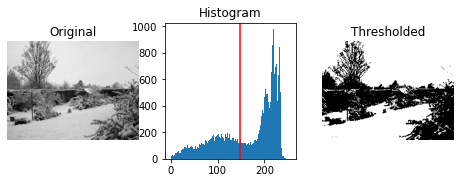

thresh= 240
method:kittler
threshold=240.000000


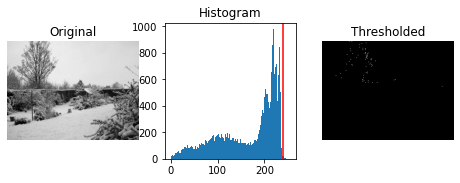

thresh= 145
method:kurita
threshold=145.000000


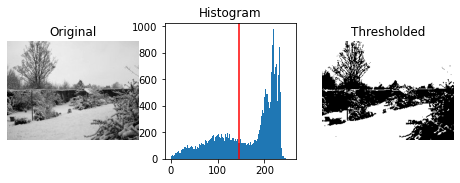

In [7]:
image = io.imread('https://github.com/namoshi/thresh/blob/main/snow.jpg?raw=true')
methods = ['otsu', 'kittler', 'kurita']

for mth in methods:
    
    thresh = threshold_kurita(image, method=mth)
    print("method:" + mth)
    print("threshold=%f"%thresh)
    
    binary = image > thresh

    fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].hist(image.ravel(), bins=256)
    ax[1].set_title('Histogram')
    ax[1].axvline(thresh, color='r')

    ax[2].imshow(binary, cmap=plt.cm.gray)
    ax[2].set_title('Thresholded')
    ax[2].axis('off')

    plt.show()
    